In [416]:
# %pip install -U gymnasium
# %pip install -U gymnasium[classic-control]
# %pip install -U ipywidgets
# %pip install -U swig
# # note: this is required for LunarLander and for windows you'll need:
# #       "Visual Studio Build Tools" with the "Desktop development with C++" for a whooping 6GB of disk -_-
# %pip install -U gymnasium[box2d]

In [417]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as widgets
from IPython.display import clear_output
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [418]:
LR = 3e-4
GAMMA = 0.99
MAX_STEPS = 1000
N_HIDDEN = 32
EPS = torch.finfo(torch.float32).eps
ENTROPY_REGULARIZATION = 0.001

In [419]:
# env = gym.make('CartPole-v1', render_mode='rgb_array')
env = gym.make("LunarLander-v2", render_mode='rgb_array')
# env = gym.make("LunarLander-v2", render_mode='human')

IN = env.observation_space.shape[0]
OUT = env.action_space.n

## utils

In [482]:
def plot_score(scores, validations=None, window=50, validation_rate=100):
    averages = []
    running_sum = sum(scores[:window])
    for i in range(window, len(scores)):
        running_sum += scores[i] - scores[i - window]
        averages.append(running_sum / window)
    plt.plot(scores, label='exploration')
    plt.plot(averages, label=f'exploration[-{window}:].mean()')
    if validations:
        x = torch.arange(len(validations)) * validation_rate
        plt.plot(x, validations, label='exploitation')
    plt.legend()
    plt.show()

In [429]:
@torch.no_grad()
def validation(env, policy, max_steps=MAX_STEPS, epochs=5):
    episodes_len = 0
    rewards = 0
    for _ in range(epochs):
        state, _ = env.reset()
        for t in range(max_steps):
            action = policy(torch.tensor(state).to(device)).argmax().item()
            state, reward, done, _, _ = env.step(action)
            rewards += reward
            if done:
                break
        episodes_len += t
    return episodes_len / epochs, rewards / epochs

In [422]:
@torch.no_grad()
def show_play(env, policy, max_steps=MAX_STEPS):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.axis('off')
    state, _ = env.reset()
    img = ax.imshow(env.render())
    score = 0
    for t in range(max_steps):
        actions = policy(torch.tensor(state).float().to(device))
        action = actions.argmax()
        state, reward, done, _, _ = env.step(action.item())
        score += reward
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done:
            print("Episode finished after {} timesteps".format(t + 1))
            break
    print(f'{score=:.2f}')

In [423]:
def discount_rewards(rewards, gamma):
    '''
    Compute the discounted rewards backwards through time, e.g.
      r0 + gamma * (r1 + gamma * (r2 + gamma * (...)))
      [----------------------------------------------]
         ^         [---------------------------------]
         |           ^           [-------------------]
      discount[0]    |             ^           [-----]
                  discount[1]      |             ^
                                discount[2]      |
                                              discount[n]                                              
    '''
    reward = 0
    discounted_rewards = []
    for r in rewards[::-1]:
        reward = r + gamma * reward
        discounted_rewards.append(reward)
    return torch.tensor(discounted_rewards[::-1], dtype=torch.float32).to(device)

## REINFORCE

REINFORCE → REward Increment = Nonnegative Factor x Offset Reinforcement x Characteristic Eligibility

In [424]:
class ReinforcePolicy(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

In [425]:
r_policy = ReinforcePolicy(n_in=IN, n_out=OUT).to(device)
r_scores = []
r_validations = []

### train

In [430]:
def train(model, epochs=10, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS, log_every=100, scores=r_scores, entropy_regularization=ENTROPY_REGULARIZATION):
    model = model.to(device)
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs, entropies = [], [], []
        explored = 0
        state, _ = env.reset()
        # forward
        for t in range(max_steps):
            # this feel bad performance wise, 1 cycle GPU, 1 cycle CPU
            # it's too much context switching
            # how can I benchmark this in a notebook?
            actions = model(torch.tensor(state).to(device))
            action = torch.multinomial(actions, 1)
            explored += action != actions.argmax()
            state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(actions[action].log())
            entropies.append(-(actions * torch.log(actions)).sum()) # prey for no NaNs (otherwise add a + EPS)
            if done:
                break
        # backward
        losses = []
        discounted_rewards = discount_rewards(rewards, gamma)
        normalized_discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + EPS)
        for log_prob, reward in zip(log_probs, normalized_discounted_rewards):
            losses.append(-log_prob * reward)
        entropy_loss = - torch.stack(entropies).sum() # negative because we want to increase entropy
        loss = torch.stack(losses).sum() + entropy_regularization * entropy_loss
        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch % log_every == 0:
            val_len, val_score = validation(env, model)
            r_validations.append(val_len)
            print(f'{epoch:<5} loss={loss.item():>7.2f} explore={100 * explored.item() / t:>5.2f} % reward={sum(rewards):>7.2f} v_rew={val_score:>7.2f} score={t:>5} validation={val_len:.0f}')

        scores.append(t)
    model.eval()

train(r_policy, epochs=1000)
plot_score(r_scores, r_validations)

0     loss=  -0.13 explore=70.16 % reward=-265.61 v_rew=-291.66 score=  124 validation=68


KeyboardInterrupt: 

In [ ]:
# save
# ----
# torch.save(r_policy.state_dict(), 'weights/lunarlander-reinforce.pt')

# load
# ----
# m = ReinforcePolicy(n_in=4, n_out=2).to(device)
# m.load_state_dict(torch.load('weights/cartpole-reinforce.pt'))

### play

Episode finished after 126 timesteps


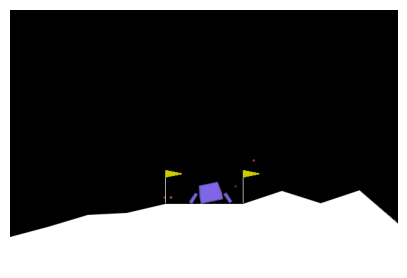

In [ ]:
show_play(env, r_policy)

### profiling

In [ ]:
# split the code in a bunch of functions to make the cProfile easier to read

def gpu_world(model, arg):
    return model(arg)

def cpu_world_simulate_env(env, action):
    return env.step(action.item())

def cpu_world_get_action(actions, log_probs):
    # Categorical seems dog slow
    # --------------------------
    # m = torch.distributions.Categorical(actions)
    # action = m.sample()
    # log_probs.append(m.log_prob(action))

    # multinormal is faster
    # ---------------------
    action = torch.multinomial(actions, 1)
    log_probs.append(torch.log(actions[action]))

    # but they should be equivalent
    # -----------------------------
    # assert m.log_prob(action) - torch.log(actions[action]) < 0.001

    return action

def cpu_world_sample(rewards, log_probs, env, actions):
    action = cpu_world_get_action(actions, log_probs)

    state, reward, done, _, _ = cpu_world_simulate_env(env, action)
    rewards.append(reward)
    return state, done

def cpu_world_backward_pass(rewards, log_probs, gamma):
    losses = []
    discounted_rewards = discount_rewards(rewards, gamma)
    normalized_discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + EPS)
    for log_prob, reward in zip(log_probs, normalized_discounted_rewards):
        losses.append(-log_prob * reward)
    return losses

def gpu_world_backward_pass(losses, opt):
    loss = torch.stack(losses).to(device).sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss

def train_for_profiling(model, epochs=100, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS):
    model = model.to(device)
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs = [], []
        state, _ = env.reset()
        # forward pass
        for _ in range(max_steps):
            actions = gpu_world(model, torch.tensor(state).float().to(device))
            state, done = cpu_world_sample(rewards, log_probs, env, actions)
            if done: break
        # backward pass
        losses = cpu_world_backward_pass(rewards, log_probs, gamma)
        loss = gpu_world_backward_pass(losses, opt)
        if epoch % 10 == 0:
            print(f'{epoch:5} {loss.item()}')

In [ ]:
import cProfile
import pstats
import io

def profile_train(model):
    pr = cProfile.Profile()
    pr.enable()
    train_for_profiling(model)
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    return s.getvalue()

profile_output = profile_train(r_policy)
print(profile_output)

    0 -3.506568670272827
   10 -0.1585693359375
   20 0.31032800674438477
   30 0.8864667415618896
   40 1.2831541299819946
   50 0.7466640472412109
   60 0.7476024627685547
   70 0.15681791305541992
   80 1.466324806213379
   90 -2.0493550300598145
         267342 function calls (246101 primitive calls) in 5.952 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.069    0.069    5.952    5.952 C:\Users\p\AppData\Local\Temp\ipykernel_33816\2794650987.py:49(train_for_profiling)
     4240    0.009    0.000    2.190    0.001 C:\Users\p\AppData\Local\Temp\ipykernel_33816\2794650987.py:27(cpu_world_sample)
      100    0.001    0.000    2.047    0.020 C:\Users\p\AppData\Local\Temp\ipykernel_33816\2794650987.py:42(gpu_world_backward_pass)
      100    0.001    0.000    1.971    0.020 c:\Users\p\Desktop\_ML\huggingface-nlp-course\venv\Lib\site-packages\torch\_tensor.py:428(backward)
      100    0.001    0.000    1.97

## REINFORCE with TD Baseline aka. Actor Critic

We introduce a `Value` (aka. `Critic`) net and rename the `Policy` into `Actor`. The `Critic` is meant to predict the expected score for a position, it is used to compute the advantage (give a baseline for how good was the episode). This is meant to help reduce the variance (converge faster).

Advantage = discounted_reward - predicted_value

In [ ]:
class ACActor(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)
    
class ACCritic(nn.Module):
    def __init__(self, n_in, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.f(x)

In [ ]:
ac_actor = ACActor(n_in=IN, n_out=OUT).to(device)
ac_critic = ACCritic(n_in=IN).to(device)
ac_scores = []
ac_validations = []

### train

0     actor_loss:   6440.47 critic_loss:     22.98 explore: 21.29% len:  263 val_len:  345 score:    258 val_score:    239
100   actor_loss:  10673.94 critic_loss:     28.19 explore: 25.37% len:  201 val_len:  353 score:    291 val_score:    238
200   actor_loss:   9569.98 critic_loss:     29.37 explore: 25.41% len:  185 val_len:  358 score:    275 val_score:    251
300   actor_loss:  12328.07 critic_loss:     28.33 explore: 26.29% len:  194 val_len:  300 score:    266 val_score:    271
400   actor_loss:  10200.42 critic_loss:     21.66 explore: 23.02% len:  252 val_len:  338 score:    275 val_score:    269
500   actor_loss:  10509.59 critic_loss:     38.60 explore: 26.24% len:  263 val_len:  349 score:    288 val_score:    238
600   actor_loss:   9282.78 critic_loss:     25.50 explore: 23.83% len:  193 val_len:  335 score:    247 val_score:    240
700   actor_loss:   6480.69 critic_loss:     34.01 explore: 13.36% len:  217 val_len:  325 score:    322 val_score:    260
800   actor_loss

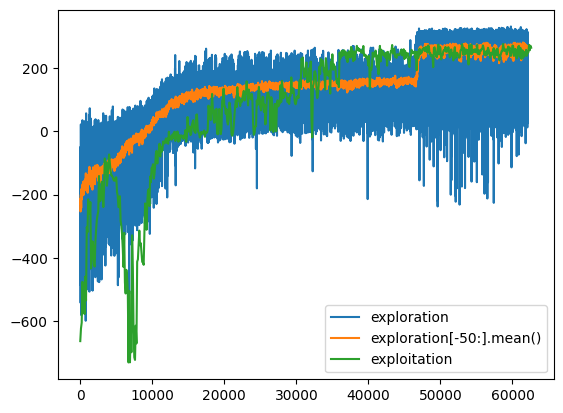

In [495]:
def ac_train(actor, critic, epochs=10, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS, log_every=100, scores=ac_scores, entropy_regularization=ENTROPY_REGULARIZATION):
    actor = actor.to(device)
    critic = critic.to(device)
    actor.train()
    critic.train()
    opt_a = optim.Adam(actor.parameters(), lr=lr)
    opt_c = optim.Adam(critic.parameters(), lr=lr)

    pad = torch.zeros(1).to(device)
    for epoch in range(epochs):
        rewards, log_probs, values, entropies = [], [], [], []
        state, _ = env.reset()
        explored = 0
        # forward
        for t in range(max_steps):
            state = torch.tensor(state).float().to(device)
            values.append(critic(state))
            actions = actor(state)
            action = torch.multinomial(actions, 1)
            explored += action != actions.argmax()
            state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(torch.log(actions[action]))
            entropies.append(-(actions * torch.log(actions)).sum()) # prey for no NaNs (otherwise add a + EPS)
            if done:
                break
        
        # backward critic
        values = torch.cat(values)
        next_values = torch.cat((values[1:].detach(), pad))
        t_rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        target = t_rewards + gamma * next_values
        critic_loss = F.mse_loss(values, target)
        opt_c.zero_grad()
        critic_loss.backward()
        opt_c.step()
        # backward actor
        losses = []
        discounted_rewards = discount_rewards(rewards, gamma)
        advantages = discounted_rewards - values.detach()
        for log_prob, advantage in zip(log_probs, advantages):
            losses.append(-log_prob * advantage)
        entropy_loss = - torch.stack(entropies).sum() # negative because we want to increase entropy
        actor_loss = torch.stack(losses).sum() + entropy_regularization * entropy_loss
        opt_a.zero_grad()
        actor_loss.backward()
        opt_a.step()

        if epoch % log_every == 0:
            val_len, val_score = validation(env, actor)
            ac_validations.append(val_score)
            print(f'{epoch:<5} actor_loss:{actor_loss.item():>10.2f} critic_loss:{critic_loss.item():>10.2f} explore:{100 * explored.item() / t:>6.2f}% len:{t:>5} val_len:{val_len:>5.0f} score:{sum(rewards):>7.0f} val_score:{val_score:>7.0f}')
        scores.append(sum(rewards))
    actor.eval()
    critic.eval()

ac_train(ac_actor, ac_critic, epochs=3000)
plot_score(ac_scores, ac_validations)

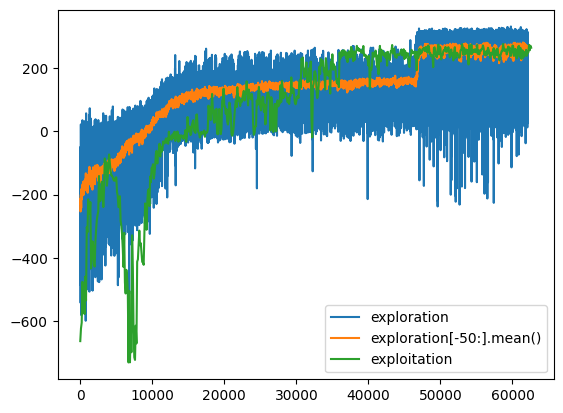

In [496]:
plot_score(ac_scores, ac_validations)

In [497]:
# save
# ----
torch.save(ac_actor.state_dict(), 'weights/ac_actor-lunarlander-long-3.pt')
torch.save(ac_critic.state_dict(), 'weights/ac_critic-lunarlander-long-3.pt')

# load
# ----
# ac_actor = ACActor(n_in=IN, n_out=OUT).to(device)
# ac_actor.load_state_dict(torch.load('weights/ac_actor-lunarlander-long.pt'))
# ac_critic = ACCritic(n_in=IN).to(device)
# ac_critic.load_state_dict(torch.load('weights/ac_critic-lunarlander-long.pt'))

### play

Episode finished after 353 timesteps
score=253.87


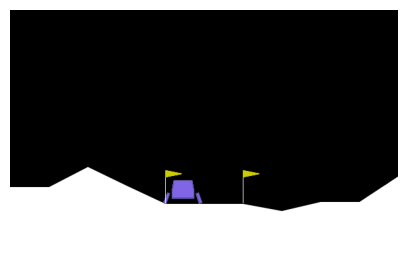

In [498]:
show_play(env, ac_actor)

## A2C (Advantage Actor Critic)

In [ ]:
class Actor(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.f(x)

actor = Actor(n_in=10, n_out=2)
critic = Critic(n_in=10)

In [ ]:
def train(epochs=100, lr=LR):
    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    for epoch in range(epochs):
        state = env.reset()
        done = False

        while not done:
            action_probs = actor(torch.from_numpy(state).float())
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, done, _ = env.step(action)

            V_current = critic(torch.from_numpy(state).float())
            V_next = critic(torch.from_numpy(next_state).float())

            # Compute advantage and TD-target
            advantage = reward + (1 - int(done)) * V_next - V_current
            td_target = reward + (1 - int(done)) * V_next

            # Update the critic
            critic_loss = advantage.pow(2)
            critic_opt.zero_grad()
            critic_loss.backward()
            critic_opt.step()

            # Update the actor
            actor_loss = -torch.log(action_probs[action]) * advantage.detach()
            actor_opt.zero_grad()
            actor_loss.backward()
            actor_opt.step()

            state = next_state

# PPO

$L^{CPI}(\theta) = \mathbb{E}_t [ \frac{\pi_\theta(a_t | s_t)}{\pi_{{\theta}_{old}(a_t | s_t)}} A_t] = \mathbb{E}_t [r_t(\theta)A_t]$

$L^{CLIP}(\theta) = \mathbb{E}_t [min(r_t(\theta)A_t, clip(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t)]$


- $\mathbb{E}$ : expected value
- $A$: advantage